# Задание для итоговой работы

# Выполнил Мурашка Андрей Владимирович

## группа 802 курс "Data-аналитик: старт карьеры "

**Анализ данных о покупках** 

Нужно выполнить предварительную обработку данных, сделать разведочный анализ данных EDA, затем проверить гипотезу о данных, выполнить кластеризацию по товарам, определить важные признаки, построить рекомендательную систему. Метод для составления рекомендаций выбрать самостоятельно.

Файл с датасетом - dataset.csv

Датасет - информация о покупках клиентов:

**Дата** - время покупки

**Транзакция** - уникальный номер покупки

**Клиент** - уникальный номер клиента

**Товар** - уникальный номер товара

**Количество** - количество купленных товаров

**Сумма** - цена покупки этого товара

### 1. Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

import datetime as dt
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
import scipy.sparse as sparse

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


# conda install -c conda-forge scikit-surprise
from surprise import Dataset, Reader
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise import accuracy
from surprise.prediction_algorithms.knns import KNNBasic



%matplotlib inline

# графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')

# увеличим дефолтный размер графиков
from pylab import rcParams

rcParams["figure.figsize"] = 10, 6
sns.set_style("whitegrid", {'axes.grid' : True})

### 2. Загрузка данных

In [2]:
df = pd.read_csv("dataset.csv", sep=';')

In [3]:
print(df.shape)
df.head()

(48303, 6)


,Дата,Транзакция,Клиент,Товар,Количество,Сумма
0,03.05.2020 21:43,954,1,2874.0,1.0,8150.0
1,20.11.2020 20:46,13796,1,3586.0,1.0,3930.0
2,08.12.2020 16:28,14431,1,4942.0,1.0,2860.0
3,03.05.2020 21:15,951,2,2812.0,1.0,4895.0
4,20.05.2020 16:46,3352,2,5025.0,1.0,840.0


### 3. Очистка данных

**Преобразование данных, обработка пропусков, удаление дубликатов**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48303 entries, 0 to 48302
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Дата        48303 non-null  object 
 1   Транзакция  48303 non-null  int64  
 2   Клиент      48303 non-null  int64  
 3   Товар       48273 non-null  float64
 4   Количество  48303 non-null  float64
 5   Сумма       48303 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 2.2+ MB


<p style="font-family: Arial; font-size:1.2em;color:gold;"> Очищаю данные от дупликатов. <br></p>

In [5]:
df = df.drop_duplicates()
df.shape

(47175, 6)

<p style="font-family: Arial; font-size:1.2em;color:gold;"> Очищаю данные от Null. <br></p>

In [6]:
df.isnull().sum()

Дата           0
Транзакция     0
Клиент         0
Товар         29
Количество     0
Сумма          0
dtype: int64

<p style="font-family: Arial; font-size:1.2em;color:gold;"> 
Данных с Null не много в столбце Товары. <br>
Просто удалим их, что бы не мешали и не портили данные.
Т.к. это товары, то бессмысленно заполнять это какими-нибудь средними значениями.
</p>

In [7]:
df = df.dropna()
df.isnull().sum()

Дата          0
Транзакция    0
Клиент        0
Товар         0
Количество    0
Сумма         0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47146 entries, 0 to 48302
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Дата        47146 non-null  object 
 1   Транзакция  47146 non-null  int64  
 2   Клиент      47146 non-null  int64  
 3   Товар       47146 non-null  float64
 4   Количество  47146 non-null  float64
 5   Сумма       47146 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 2.5+ MB


<p style="font-family: Arial; font-size:1.2em;color:gold;"> 
Вижу, что столбцы Товар и Кол-во имеют тип float64. <br>
Привожу их к более соответствующему типу int64. <br>
Добавлю новые столбцы Дата1 типа datetime64, Дата2, как дата без времени и<br>
День недели, номер недели, месяц и год для последующих вычислений.
</p>

In [9]:
df['Товар'] = df['Товар'].astype(int)
df['Количество'] = df['Количество'].astype(int)
df['Дата1'] = pd.to_datetime(df['Дата'])
df['Дата2'] = df['Дата1'].dt.date
df['Год'] = df['Дата1'].dt.year
df['Месяц'] = df['Дата1'].dt.month
df['Неделя'] = df['Дата1'].dt.week
df['День недели'] = df['Дата1'].dt.dayofweek
df.reset_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47146 entries, 0 to 48302
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Дата         47146 non-null  object        
 1   Транзакция   47146 non-null  int64         
 2   Клиент       47146 non-null  int64         
 3   Товар        47146 non-null  int64         
 4   Количество   47146 non-null  int64         
 5   Сумма        47146 non-null  float64       
 6   Дата1        47146 non-null  datetime64[ns]
 7   Дата2        47146 non-null  object        
 8   Год          47146 non-null  int64         
 9   Месяц        47146 non-null  int64         
 10  Неделя       47146 non-null  int64         
 11  День недели  47146 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(8), object(2)
memory usage: 4.7+ MB


In [10]:
df.head()

,Дата,Транзакция,Клиент,Товар,Количество,Сумма,Дата1,Дата2,Год,Месяц,Неделя,День недели
0,03.05.2020 21:43,954,1,2874,1,8150.0,2020-03-05 21:43:00,2020-03-05,2020,3,10,3
1,20.11.2020 20:46,13796,1,3586,1,3930.0,2020-11-20 20:46:00,2020-11-20,2020,11,47,4
2,08.12.2020 16:28,14431,1,4942,1,2860.0,2020-08-12 16:28:00,2020-08-12,2020,8,33,2
3,03.05.2020 21:15,951,2,2812,1,4895.0,2020-03-05 21:15:00,2020-03-05,2020,3,10,3
4,20.05.2020 16:46,3352,2,5025,1,840.0,2020-05-20 16:46:00,2020-05-20,2020,5,21,2


### 4. EDA 
 
**Описательная статистика, поиск взаимосвязей**

<p style="font-family: Arial; font-size:1.2em;color:gold;"> Смотрим общую статистику по числовым столбцам. <br></p>

In [11]:
df.describe()

,Транзакция,Клиент,Товар,Количество,Сумма,Год,Месяц,Неделя,День недели
count,47146.000000,47146.000000,47146.000000,47146.0,47146.000000,47146.000000,47146.000000,47146.000000,47146.000000
mean,13170.802974,4545.535867,3126.636745,1.0,10455.257645,2020.424426,6.494528,26.506151,2.941586
std,7668.957751,3031.557668,1655.168978,0.0,12701.269894,0.494261,3.178319,13.986683,1.901125
min,1.000000,1.000000,1.000000,1.0,504.000000,2020.000000,1.000000,1.000000,0.000000
25%,6373.250000,2000.000000,1822.000000,1.0,3810.000000,2020.000000,4.000000,16.000000,2.000000
50%,13290.500000,3922.000000,3146.000000,1.0,6910.000000,2020.000000,6.000000,26.000000,3.000000
75%,19749.000000,6903.000000,4803.000000,1.0,12750.000000,2021.000000,9.000000,38.000000,5.000000
max,26512.000000,11050.000000,5523.000000,1.0,511500.000000,2021.000000,12.000000,53.000000,6.000000


<p style="font-family: Arial; font-size:1.2em;color:gold;"> Смотрим на графики распределения плотности и разброса <br>
для количества и сумм продаж по дням.
</p>

In [12]:
df1 = df.groupby(['Дата2'])['Количество','Сумма'].sum() \
    .sort_values('Дата2', ascending = True).reset_index()
df1.head()

,Дата2,Количество,Сумма
0,2020-01-05,442,2999052.96
1,2020-01-06,26,184500.00
2,2020-01-07,60,430400.00
3,2020-01-08,25,208770.00
4,2020-01-09,92,926915.00


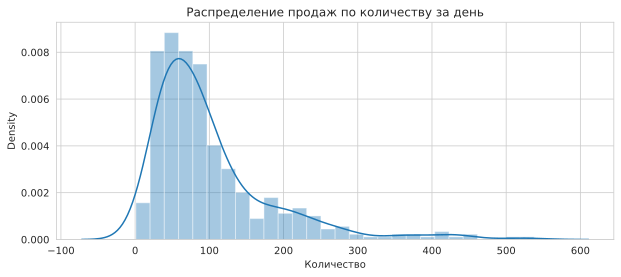

In [13]:
plt.figure(figsize=(10,4))

plt.title('Распределение продаж по количеству за день')
sns.distplot(df1.Количество)

plt.show()

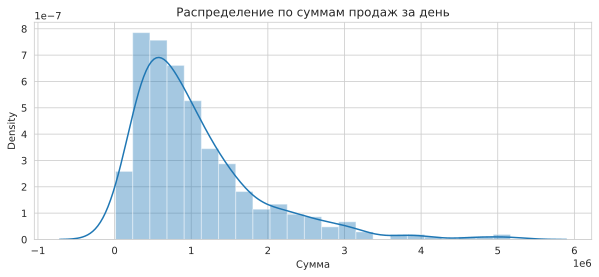

In [14]:
plt.figure(figsize=(10,4))

plt.title('Распределение по суммам продаж за день')
sns.distplot(df1.Сумма)

plt.show()

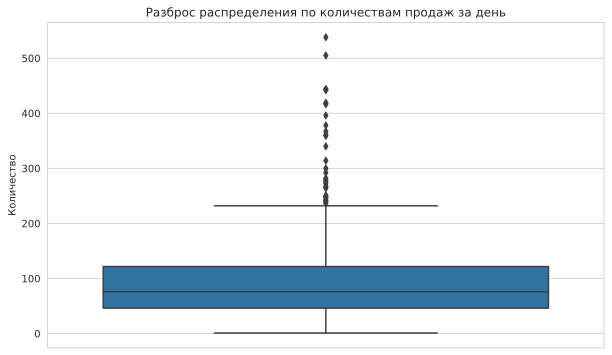

In [15]:
plt.title('Разброс распределения по количествам продаж за день')

sns.boxplot(y=df1.Количество)

plt.show()

In [16]:
df1.describe()

,Количество,Сумма
count,466.000000,4.660000e+02
mean,101.171674,1.057776e+06
std,83.034470,8.307050e+05
min,1.000000,1.245000e+04
25%,46.250000,4.825089e+05
50%,76.000000,8.242350e+05
75%,121.750000,1.365550e+06
max,538.000000,5.166122e+06


<p style="font-family: Arial; font-size:1.2em;color:gold;"> Распределение похоже на нормальное с некоторым размытием в сторону больших продаж <br>
По количеству продаж за день достаточно плотно собраны у среднего значения, но выбросы единичными назвать нельзя. 
Посмотрим как распределены продажи по дням недели и  часам.
</p>

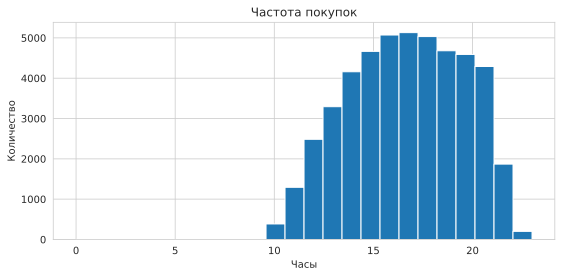

In [17]:
plt.figure(figsize=(9,4))
plt.hist(df['Дата1'].dt.hour.values, bins = 24)
plt.xlabel('Часы')
plt.ylabel('Количество')
plt.title('Частота покупок')
plt.show()

<p style="font-family: Arial; font-size:1.2em;color:gold;"> Видим, что продажи почти равномерно нарастают до обеденного времени и медленно спадают до глубокого вечера <br>
</p>

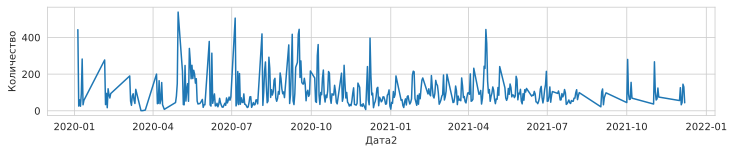

In [18]:
plt.figure(figsize=(12,2))

ax = sns.lineplot(data=df1,
            x='Дата2',
            y='Количество')
plt.show()


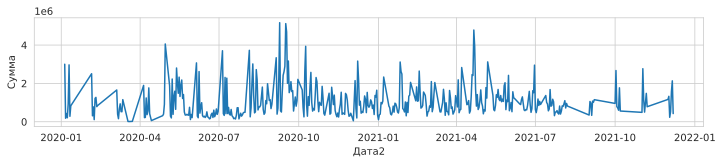

In [19]:
plt.figure(figsize=(12,2))

ax = sns.lineplot(data=df1,
            x='Дата2',
            y='Сумма')
plt.show()


<p style="font-family: Arial; font-size:1.2em;color:gold;"> Укрупним данные за последний период <br>
Видим явно выраженные пики и некоторую выраженную переодичность в конце набора данных.    
</p>

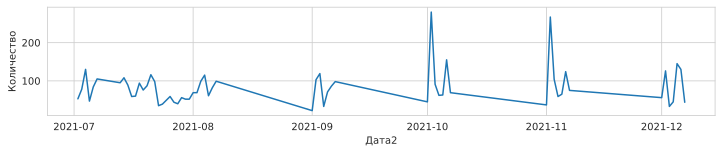

In [20]:
plt.figure(figsize=(12,2))
data = df1[406:466][['Количество','Дата2']]

ax = sns.lineplot(data=data,
            x='Дата2',
            y='Количество',
            legend='auto')
plt.show()

<p style="font-family: Arial; font-size:1.2em;color:gold;"> Видим, что в начале каждого месяца имеет место резкое увеличение продаж, с последующим медленным спадом. <br>
Возможно в начале месяца у клиентов появляется новый бюджет и это некоторый эффект от отложенных покупок.
</p>

In [21]:
data.head(60)

,Количество,Дата2
406,53,2021-07-02
407,78,2021-07-03
408,130,2021-07-04
409,47,2021-07-05
410,84,2021-07-06
411,105,2021-07-07
412,95,2021-07-13
413,108,2021-07-14
414,89,2021-07-15
415,59,2021-07-16


In [22]:
df2 = df.groupby('День недели')['Количество','Сумма'].sum()
df2.head()

,Количество,Сумма
День недели,,
0,5608,6.130244e+07
1,6177,6.572683e+07
2,9517,1.019837e+08
3,8337,8.386218e+07
4,5598,5.780936e+07


<p style="font-family: Arial; font-size:1.2em;color:gold;"> Если сгруппировать по дням недели, видно, что в выходные дни продаж нет.<br>
    Значит либо магазин по выходным не работает, либо наши клиенты корпоративные.<br>
    Так же можно посмотреть список товаров, проданных на самые большие суммы.
</p>

In [23]:
df3 = df[['Товар','Количество','Сумма']].groupby('Товар').sum().sort_values('Сумма', ascending = False).reset_index()
df3.head()

,Товар,Количество,Сумма
0,3060,156,7114347.53
1,4757,281,6684277.87
2,4944,725,5092324.27
3,3487,435,4566229.85
4,2430,94,3805189.37


**Корреляция**

<p style="font-family: Arial; font-size:1.2em;color:gold;"> Выберем столбцы, по которым будем искать корреляцию.<br>
</p>

In [24]:
df4 = df[['Клиент','Товар','Количество','Сумма','Дата2','Неделя','Месяц','Год']]

In [25]:
# sns.pairplot(df4)
# plt.show()

<p style="font-family: Arial; font-size:1.2em;color:gold;"> Построим корреляционную матрицу по методу Спермана.<br>
    Выведем значения большие 50.
</p>

In [26]:
corr_spearman = df4.corr(method='spearman')
corr_spearman_gr_than_50 = corr_spearman[corr_spearman >= .5]
corr_spearman_gr_than_50

,Клиент,Товар,Количество,Сумма,Неделя,Месяц,Год
Клиент,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Товар,NaN,1.0,NaN,NaN,NaN,NaN,NaN
Количество,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Сумма,NaN,NaN,NaN,1.0,NaN,NaN,NaN
Неделя,NaN,NaN,NaN,NaN,1.000000,0.983827,NaN
Месяц,NaN,NaN,NaN,NaN,0.983827,1.000000,NaN
Год,NaN,NaN,NaN,NaN,NaN,NaN,1.0


<p style="font-family: Arial; font-size:1.2em;color:gold;"> Построим корреляционную матрицу по методу Пирсона.<br>
    Выведем значения большие 50.
</p>

In [27]:
corr_pearson = df4.corr(method='pearson')
corr_pearson_gr_than_50 = corr_pearson[corr_spearman >= .5]
corr_pearson_gr_than_50

,Клиент,Товар,Количество,Сумма,Неделя,Месяц,Год
Клиент,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Товар,NaN,1.0,NaN,NaN,NaN,NaN,NaN
Количество,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Сумма,NaN,NaN,NaN,1.0,NaN,NaN,NaN
Неделя,NaN,NaN,NaN,NaN,1.000000,0.981927,NaN
Месяц,NaN,NaN,NaN,NaN,0.981927,1.000000,NaN
Год,NaN,NaN,NaN,NaN,NaN,NaN,1.0


<p style="font-family: Arial; font-size:1.2em;color:gold;"> Нашли что порядковый номер месяца почти на 100 % коррелирует с порядковым номером недели.<br>
Как то неожиданно право, что переодические функции от времени так сильно коррелируют.<br>
 Сгруппируем данные помесячно и повторим.
</p>

In [28]:
df4['YM'] = df4['Год'].map(str) + df4['Месяц'].map(str)
df4

,Клиент,Товар,Количество,Сумма,Дата2,Неделя,Месяц,Год,YM
0,1,2874,1,8150.0,2020-03-05,10,3,2020,20203
1,1,3586,1,3930.0,2020-11-20,47,11,2020,202011
2,1,4942,1,2860.0,2020-08-12,33,8,2020,20208
3,2,2812,1,4895.0,2020-03-05,10,3,2020,20203
4,2,5025,1,840.0,2020-05-20,21,5,2020,20205
...,...,...,...,...,...,...,...,...,...
48298,11049,1211,1,20500.0,2021-06-07,23,6,2021,20216
48299,11049,3034,1,21950.0,2021-06-07,23,6,2021,20216
48300,11050,443,1,1490.0,2021-06-07,23,6,2021,20216
48301,11050,2789,1,9450.0,2021-06-07,23,6,2021,20216


In [29]:
df5 = df4.groupby(['YM']).sum()[['Количество','Сумма']]
df5.head()

,Количество,Сумма
YM,,
20201,1017,8835526.23
202010,3173,33949027.21
202011,2029,20131949.63
202012,2420,28403133.65
20202,795,7833534.37


In [30]:
df5['NEW'] = df5.index
df5.head()

,Количество,Сумма,NEW
YM,,,
20201,1017,8835526.23,20201
202010,3173,33949027.21,202010
202011,2029,20131949.63,202011
202012,2420,28403133.65,202012
20202,795,7833534.37,20202


In [31]:
corr_spearman_2 = df5.corr(method='spearman')
corr_spearman_2_gr_than_50 = corr_spearman_2[corr_spearman_2 >= .5]
corr_spearman_2_gr_than_50

,Количество,Сумма
Количество,1.00,0.98
Сумма,0.98,1.00


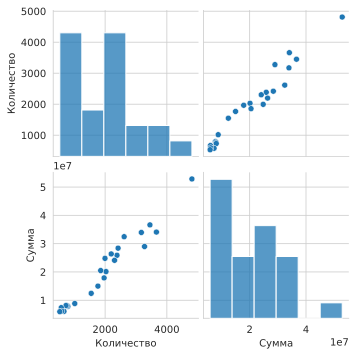

In [32]:
sns.pairplot(df5)
plt.show()

<p style="font-family: Arial; font-size:1.2em;color:gold;"> Когда убрали разбивки на отдельные транзакции получили ожидаемую почти 100 процентную корреляцию суммы и количества, и можно сделать вывод, что данные в целом достоверные.<br>
Попробуем снова, но не будем включать транзакцию, и временной период, как факторы корреляции.
</p>

In [33]:
corr_spearman_3 = df[['Клиент','Товар','Количество','Сумма']].corr(method='spearman')
corr_spearman_3

,Клиент,Товар,Количество,Сумма
Клиент,1.000000,0.026140,NaN,0.102661
Товар,0.026140,1.000000,NaN,0.121602
Количество,NaN,NaN,NaN,NaN
Сумма,0.102661,0.121602,NaN,1.000000


<p style="font-family: Arial; font-size:1.2em;color:gold;"> Результат лучше не стал.<br>
Видимо клиенты и товары слишком разные, что бы проявились сильные корреляции.<br>
Но все равно построим тепловую карту.
    Более хорошую корреляцию признаков обнаружем позже, когда будем изучать гипотезу.
</p>

<AxesSubplot:>

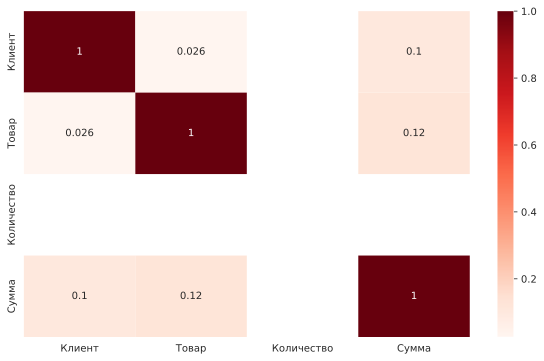

In [34]:
sns.heatmap(corr_spearman_3, cmap='Reds', annot=True)

### 5.	Выполнить проверку гипотез о данных

5.1 Зависит ли частота покупок от месяца?

<p style="font-family: Arial; font-size:1.2em;color:gold;">
Посчитаем количество проданного товара в месяц и построим график.<br>
</p>

In [35]:
df6 = df.groupby(['Год','Месяц'])['Товар'].count().reset_index()
df6['date'] = df6.index
#df6

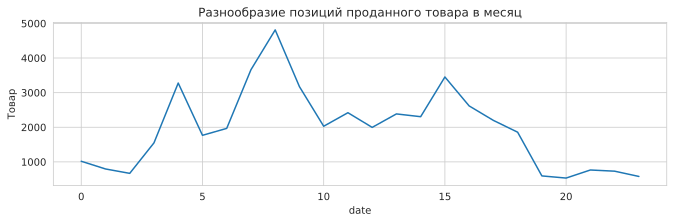

In [36]:
plt.figure(figsize=(11,3))
ax = sns.lineplot(data=df6,
            x = 'date',
            y = 'Товар',
            
                  
            legend='auto')
plt.title('Разнообразие позиций проданного товара в месяц')
plt.show()

<p style="font-family: Arial; font-size:1.2em;color:gold;">
Видим, что в конце исследуемого периода разнообразие позиций проданного товара в месяц значительно уменьшается.<br>
Мы видели на графике, что помесячные суммы продаж так себя не вели.<br>
Предположим, что количество товара и средняя сумма в транзакции к концу периода возрастают.<br>
  Сделаем вычисления и построим графики.
</p>

In [37]:
df61 = df.groupby(['Год','Месяц','Транзакция'])['Количество'].count().reset_index()
df62 = df61.groupby(['Год','Месяц']).agg({'Транзакция':lambda x: len(x),
                                        'Количество':lambda x: sum(x)}).reset_index()
df62['date'] = df62.index
df62['procent'] = df62['Количество']/df62['Транзакция']
№df62

SyntaxError: invalid character '№' (U+2116) (2600608363.py, line 6)

In [ ]:
plt.figure(figsize=(11,3))
ax = sns.lineplot(data=df62,
            x = 'date',
            y = 'procent',
            legend='auto')
plt.title('Относительное количество товаров в каждой транкзакции по времени')
plt.show()

In [ ]:
df63 = df.groupby(['Год','Месяц','Транзакция'])['Сумма'].sum().reset_index()
df64 = df63.groupby(['Год','Месяц']).agg({'Транзакция':lambda x: len(x),
                                        'Сумма':lambda x: sum(x)}).reset_index()
df64['date'] = df64.index
df64['mean_sum'] = df64['Сумма']/df64['Транзакция']
df64

In [ ]:
plt.figure(figsize=(11,3))
ax = sns.lineplot(data=df64,
            x = 'date',
            y = 'mean_sum',
            legend='auto')
plt.title('Средняя сумма транкзакции по времени')
plt.show()

<p style="font-family: Arial; font-size:1.2em;color:gold;">
Гипотеза об увеличении среднего чека к концу исследуемого периода подтвердилась.<br>
    Попробуем построить корреляцию на основе вновь рассчитанных столбцов.<br>
    Для этого объединим рассчитанные признаки в одну таблицу.
</p>

In [ ]:
df65 = pd.merge(df6, df62, how='inner', on='date')
df66 = pd.merge(df64, df65, how='inner', on='date')
df66 = df66.rename(columns={'mean_sum': 'Средняя_Сумма', 'procent': 'Среднее_число_товаров_в_транзакции', 'Транзакция_x': 'Среднее_число_транзакций', 'Количество': 'Среднее_число_штук'})
#df66

In [ ]:
corr_spearman_4 = df66[['Год','Месяц','Сумма','Средняя_Сумма','Среднее_число_транзакций','Среднее_число_штук','Среднее_число_товаров_в_транзакции']].corr(method='spearman')
corr_spearman_4_gr_than_50 = corr_spearman_4[corr_spearman_4 >= .5]
corr_spearman_4_gr_than_50

In [ ]:
sns.heatmap(corr_spearman_4_gr_than_50, cmap='Reds', annot=True)

<p style="font-family: Arial; font-size:1.2em;color:gold;">
Видим, что корреляций на сгруппированных признаках , гораздо больше.<br>
    Можно предположить, что сильная детализация заглушает белым шумом возможные корреляции.<br>
    Сумма среднего чека могла возрасти и в случае сильного и повсеместного повышения прайсовых цен.<br>
    Оценим этот фактор, взяв данные за апрель 2021, после которого наблюдался стабильный подъем показателей, и ноябрем 2021, последним месяцем с полными данными.
</p>

In [ ]:
dfs63 = df.groupby(['Год','Месяц','Товар'])['Сумма','Количество'].sum().reset_index()

dfs63['mean_price'] = dfs63['Сумма']/dfs63['Количество']

dfs63['YM'] = dfs63['Год'].map(str) + dfs63['Месяц'].map(str)

dfs64 = pd.merge(dfs63[(dfs63['YM'] == '20214')], dfs63[(dfs63['YM'] == '202111')], how='inner', on='Товар')

dfs64['PRC'] = (dfs64['mean_price_y']/dfs64['mean_price_x'])*100

dfs64

In [ ]:
dfs65 = dfs64['PRC']
dfs65.describe()

<p style="font-family: Arial; font-size:1.2em;color:gold;">
Видим, что однозначного повышения цен не было. В среднем прайсовая цена даже несколько уменьшилась.<br>
    Можно предположить, что влияние прайсовой цены на увеличение суммы чека не является определяющим.<br>
    Что бы понять, меняется ли структура клиентов, оценим лучших и потерянных клиентов.
</p>

 5.2 Больше лучших клиентов, чем потерянных клиентов?
 
 Т.е. выяснить больше ли клиентов, которые покупали совсем недавно, чаще всего и тратят больше всего, 
 чем клиентов, у которых последняя покупка была давно, и покупали мало и тратили мало.

<p style="font-family: Arial; font-size:1.2em;color:gold;">
Подготовим набор данных.<br>
    Просуммируем суммы и количества в разрезе клиентов дат и покупок.
</p>

In [ ]:
Now = df['Дата2'].max()

df_7 = df.groupby(['Транзакция','Клиент','Дата2'])['Количество','Сумма'].sum() \
    .reset_index().drop_duplicates()

df_8 = df_7.groupby('Клиент').agg({'Дата2':lambda x: (Now - x.max()).days, 
                                   'Транзакция':lambda x: len(x),
                                        'Сумма':lambda x: sum(x)})
df_8.head()

<p style="font-family: Arial; font-size:1.2em;color:gold;">
Проверим, как это все раскладывается по стандартным процентилям.<br>
</p>

In [ ]:
df_8.describe()

<p style="font-family: Arial; font-size:1.2em;color:gold;">
Возьмем процентиль пяти процентов сверху и сохраним граничные величины.<br>
    Посмотрим сколько клиентов входит в верхнии границы по отдельности.
</p>

In [ ]:
q_d_max = df_8['Дата2'].quantile(0.95)
q_t_max = df_8['Транзакция'].quantile(0.95)
q_s_max = df_8['Сумма'].quantile(0.95)

q_d_max, q_t_max, q_s_max

In [ ]:
q_d_max_c = df_8[df_8['Дата2']>q_d_max]['Дата2'].count()
q_t_max_c = df_8[df_8['Транзакция']>q_t_max]['Транзакция'].count()
q_s_max_c = df_8[df_8['Сумма']>q_s_max]['Сумма'].count()

q_d_max_c, q_t_max_c, q_s_max_c

<p style="font-family: Arial; font-size:1.2em;color:gold;">
Возьмем процентиль пяти процентов снизу и сохраним граничные величины.<br>
    Посмотрим сколько клиентов входит в нижнии границы по отдельности.
</p>

In [ ]:
q_d_min = df_8['Дата2'].quantile(0.05)
q_t_min = df_8['Транзакция'].quantile(0.05)
q_s_min = df_8['Сумма'].quantile(0.05)

q_d_min, q_t_min, q_s_min

In [ ]:
q_d_min_c = df_8[df_8['Дата2']<q_d_min]['Дата2'].count()
q_t_min_c = df_8[df_8['Транзакция']<=q_t_min]['Транзакция'].count()
q_s_min_c = df_8[df_8['Сумма']<q_s_min]['Сумма'].count()

q_d_min_c, q_t_min_c, q_s_min_c

<p style="font-family: Arial; font-size:1.2em;color:gold;">
Посчитаем, сколько у нас хороших и плохих клиентов.<br>
    Учтем, что чем меньше времени прошло с последней покупки, тем клиент лучше.
</p>

In [ ]:

clients_good = df_8[(df_8['Дата2']<q_d_min) & (df_8['Транзакция']>q_t_max) & (df_8['Сумма']>q_s_max)]['Транзакция'].count()

clients_bad = df_8[(df_8['Дата2']>q_d_max) & (df_8['Транзакция']<=q_t_min) & (df_8['Сумма']<q_s_min)]['Транзакция'].count()

clients_good, clients_bad

<p style="font-family: Arial; font-size:1.2em;color:gold;">
Хороших клиентов больше.<br>
    Это косвенно согласуется с прошлыми исследованиями, что в конце исследуемого периода покупать стали больше штук и на большие суммы. 
</p>

### 6. Кластеризация по товарам

<p style="font-family: Arial; font-size:1.2em;color:gold;"> Подготовим данные.<br>
</p>

In [ ]:
df_sum = df.groupby(['Товар'])['Количество','Сумма'].sum().reset_index()
df_sum.head()

<p style="font-family: Arial; font-size:1.2em;color:gold;">  Кластерный анализ будем проводить по модели K средних.<br>
    Посчитаем результаты модели в диапазоне разбивки от 1 до 15 кластеров.
</p>

In [ ]:
sd = []
x = df_sum[['Количество','Сумма']].to_numpy()

for i in range(1, 15):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(x) #Вычислить кластеризацию k-средних.
    sd.append(kmeans.inertia_)

In [ ]:
plt.plot(range(1, 15), sd)
plt.title('Метод локтя')
plt.xlabel('Номер кластера')
plt.ylabel('Внутрикластерная сумма квадратов') 
plt.show

<p style="font-family: Arial; font-size:1.2em;color:gold;">  Наилучшее разделение получается при разбивке на 5 кластеров.<br>
    Выберем его для модели и сохраним разбивку на 5 кластеров в нашем датасете.
</p>

In [ ]:
kmeans = KMeans(n_clusters = 5, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_kmeans = kmeans.fit(x)
labels1 = kmeans.labels_
centroids1 = kmeans.cluster_centers_
Z = y_kmeans.predict(x)
df_sum['seg'] = Z
df_sum.head()

In [ ]:
df_sum.groupby(['seg'])[['Количество', 'Сумма']].mean()

<p style="font-family: Arial; font-size:1.2em;color:gold;">  
    Видим, что только 2 и 4 категории пересекаются по кол-ву, что весьма удовлетворительно.
</p>

In [ ]:
# plot
sns.boxplot(x=df_sum['seg'], y=df_sum['Количество'], data=df_sum)

<p style="font-family: Arial; font-size:1.2em;color:gold;">  
    Видим, что по сумме пересечений совсем нет, что просто великолепно.
</p>

In [ ]:
# plot
sns.boxplot(x=df_sum['seg'], y=df_sum['Сумма'], data=df_sum)

<p style="font-family: Arial; font-size:1.2em;color:gold;">  На диаграмме рассеивания видим, что разделение на категории при разбивке на 5 сегментов делит нашу выборку весьма четко.<br>
    </p>

In [ ]:
plt.scatter(x = df_sum['Количество'], y = df_sum['Сумма'], 
            c = df_sum['seg'], alpha = 0.6, cmap = 'cool')
plt.xlabel('Количество')
plt.ylabel('Сумма')

### 7. Важные признаки

<p style="font-family: Arial; font-size:1.2em;color:gold;"> Мы нацелились на построение рекомендательной системы, которая сможет предлагать нашим клиентам товары, <br>
поэтому оценим важность признаков в нашем датасете относительно купленного товара.<br>
    Т.е. выберем Товар, как наш целевой признак.
</p>

<p style="font-family: Arial; font-size:1.2em;color:gold;"> Создадим новый фрейм,<br>
    включив в него полную дату и месяц.<br>
    Посмотрим, будет ли разница в важности в зависимости от точности указания времени совершения транзакций.<br>
    Что бы модель работала, пришлось перевести дату в целочисленный относительный формат.
    </p>

In [ ]:
df_v = df[['Дата2','Месяц','Клиент','Транзакция','Количество','Сумма','Товар']]
Now = df['Дата2'].max()
df_v['Дата2'] = df_v['Дата2'].apply(lambda x: (Now - x).days)
df_v.head()

In [ ]:
X = df_v[['Дата2','Месяц','Клиент','Транзакция','Количество','Сумма']]
y = df_v.iloc[:, -1]

In [ ]:
bestfeatures = SelectKBest(score_func = chi2, k = 'all')
fit = bestfeatures.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns, dfscores], axis = 1)
featureScores.columns = ['Specs', 'Score']  
print(featureScores.nlargest(10, 'Score'))  

<p style="font-family: Arial; font-size:1.2em;color:gold;"> Получается,что все признаки, кроме Количества являются значимыми.<br>
    Количество всегда в нашей таблице равно "единице", и следовательно<br>
     как признак Количество не значимо, просто константа.<br>
 </p>

### 8.	Рекомендации

<p style="font-family: Arial; font-size:1.2em;color:gold;"> Построим рекомендательную  систему на основе предпочтений похожих клиентов,<br>
 используя функцию косинуса в методе K ближайших соседей по алгоритму SVD.
 </p>

<p style="font-family: Arial; font-size:1.2em;color:gold;"> Подготовим данные.<br>
  </p>

In [ ]:
df_rec = df[['Товар','Клиент','Количество']].groupby(['Товар','Клиент']) \
            .sum().sort_values('Количество', ascending=False).reset_index()
df_rec

<p style="font-family: Arial; font-size:1.2em;color:gold;"> Загружаем данные. Строим датасет.<br>
  </p>

In [ ]:
reader = Reader(line_format='user item rating', sep=',', rating_scale=(0,5), skip_lines=1)

data1 = Dataset.load_from_df(df_rec[['Клиент','Товар','Количество']].iloc[:41370,:], reader=reader)

trainset = data1.build_full_trainset()

<p style="font-family: Arial; font-size:1.2em;color:gold;"> Настраиваем и обучаем модель.<br>
  </p>

In [ ]:
sim_options = {'name': 'cosine',
               'user_based': True}

# KNN 
sim_user = KNNBasic(sim_options=sim_options, verbose=False, random_state=33)

sim_user.fit(trainset)

<p style="font-family: Arial; font-size:1.2em;color:gold;"> Реализуем функцию выбора рекомендаций для товаров, некупленных клиентом, отранжированных по большей степени сходства и ограниченных первыми top_n параметрами, если est лучше чем 3.812.<br>
  </p>

In [ ]:
def get_recommendations_n(data, user_id, top_n, algo):
    
    recommendations = []
    
    user_products_interactions_matrix = data.pivot(index='Клиент', columns='Товар', values='Количество')
    
    non_interacted_products = user_products_interactions_matrix.loc[user_id][user_products_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    for item_id in non_interacted_products:
        
        est = algo.predict(user_id, item_id).est
        
        if est > 3.812 :
            
            recommendations.append((item_id, est))
        
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] 

<p style="font-family: Arial; font-size:1.2em;color:gold;"> Проверяем для клиентов ручное предсказание.<br>
    Получаем близкое к реально существующему предсказанное значение.<br>
  </p>

In [ ]:
sim_user.predict(uid=7172,iid=2523)

In [ ]:
sim_user.predict(uid=6967,iid=2523)

<p style="font-family: Arial; font-size:1.2em;color:gold;"> Проверяем для клиентов функцию получения рекомендаций.<br>
    Функция выдает рекомендации ограниченные 10 первыми позициями, если они превышают минимальный порог est.<br>
  </p>

In [ ]:
get_recommendations_n(df_rec,22,10,sim_user)

In [ ]:
get_recommendations_n(df_rec,7172,10,sim_user)

In [ ]:
get_recommendations_n(df_rec,4698,10,sim_user)

## Вывод